# Softmax 回歸分析

## Softmax 函數

一般而言，假設向量 $\pmb z = (z_1, z_2, \dots, z_k, \dots, z_C)$，並以 $f(\pmb z)$ 表示 $Softmax(\pmb z)$ 函數，則定義如下：

$$f_i = \frac{e^{z_i}}{\sum_{k=1}^C e^{z_k}}$$

其中，所有輸出成分的和為 1，即 $\sum_{i=1}^C f_i = 1$。這使得 Softmax 的輸出可以被視為一種機率分佈。梯度計算$\pmb f$ 對於 $\pmb z$ 的**梯度（Gradient）**

計算如下：當我們計算偏微分 $\frac{\partial f_i}{\partial z_j}$ 時，需要分兩種情況討論（使用微積分的商鎖定律）：當 $i = j$ 時：

$$\frac{\partial f_i}{\partial z_i} = f_i (1 - f_i)$$

當 $i \neq j$ 時：

$$\frac{\partial f_i}{\partial z_j} = -f_i f_j$$

因此，Softmax 的雅可比矩陣（Jacobian Matrix）可以統一表示為：

$$\frac{\partial f_i}{\partial z_j} = f_i (\delta_{ij} - f_j)$$

其中 $\delta_{ij}$ 為 Kronecker delta 函數（當 $i=j$ 時為 1，否則為 0）。

以下程式碼透過視覺化的方式，生動地展示了 Softmax 函數 如何將連續的數值（Logits）轉換成機率分佈。這對於理解多分類模型中「模型信心度」的變化非常有幫助。

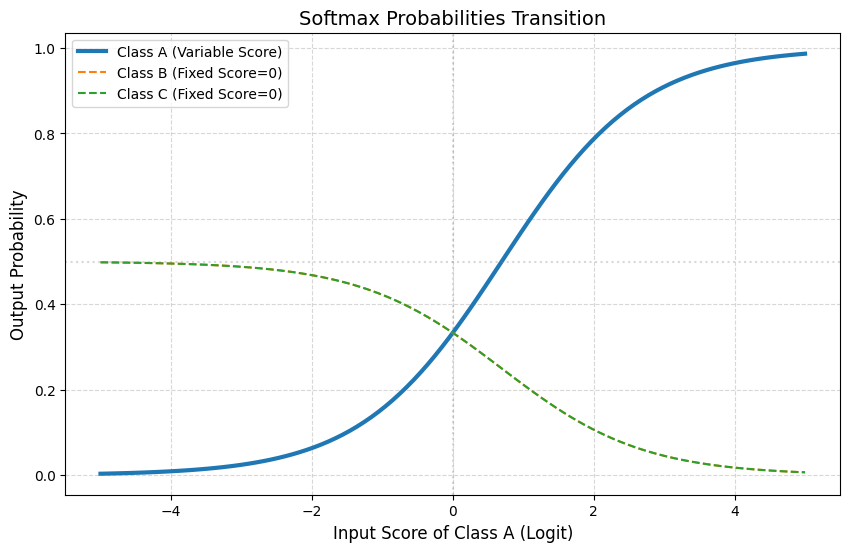

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# def softmax(z):
#     # 數值穩定版 Softmax：減去最大值避免指數溢位 (Overflow)
#     # 這裡 axis=0 是因為輸入矩陣 logits 的維度設計為 (類別數, 樣本數)
#     exp_z = np.exp(z - np.max(z, axis=0))
#     return exp_z / np.sum(exp_z, axis=0)

def softmax(x, axis=-1):
    if axis < -x.ndim or axis >= x.ndim:
        raise ValueError(f"Invalid axis {axis} for shape {x.shape}")

    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    sum_exp = np.sum(exp_x, axis=axis, keepdims=True)

    return exp_x / sum_exp


# 建立 X 軸：類別 A 的分數 (Logit) 從 -5 變動到 5
x = np.linspace(-5, 5, 100)

# 假設共有三個類別：
# 讓類別 A 的得分隨 x 軸變動
# 固定類別 B 和類別 C 的得分為 0
logits = np.vstack([x, np.zeros_like(x), np.zeros_like(x)])

# 透過 Softmax 將得分轉換為機率
probs = softmax(logits, 0)

# --- 繪圖 (Visualization) ---
plt.figure(figsize=(10, 6))

# 繪製各類別的機率曲線
plt.plot(x, probs[0], label='Class A (Variable Score)', linewidth=3, color='#1f77b4')
plt.plot(x, probs[1], label='Class B (Fixed Score=0)', linestyle='--', color='#ff7f0e')
plt.plot(x, probs[2], label='Class C (Fixed Score=0)', linestyle='--', color='#2ca02c')

# 標註圖表資訊
plt.title("Softmax Probabilities Transition", fontsize=14)
plt.xlabel("Input Score of Class A (Logit)", fontsize=12)
plt.ylabel("Output Probability", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

# 繪製輔助線（y=0.5 門檻與 x=0 對齊線）
plt.axhline(y=0.5, color='gray', alpha=0.3, linestyle=':')
plt.axvline(x=0, color='gray', alpha=0.3, linestyle=':')

plt.show()

## 交叉熵與交叉熵損失函數

In [3]:
import numpy as np

def cross_entropy(F, y):
    """
    計算多分類交叉熵損失
    F: 預測機率矩陣，形狀為 (樣本數, 類別數)，由 Softmax 輸出
    y: 正確答案的索引標籤，形狀為 (樣本數,)
    """
    m = len(F) # 取得樣本總數

    # 關鍵技巧：利用進階索引 (Advanced Indexing)
    # F[range(m), y] 會從每一列 (每個樣本) 中，只取出正確類別 y 所對應的機率值
    # 例如：第 0 個樣本取 index 2，第 1 個樣本取 index 1
    log_Fy = -np.log(F[range(m), y])

    # 回傳平均損失值值
    return np.sum(log_Fy) / m

# 測試資料：2 個樣本，3 個類別
# F 矩陣中每一列代表一個樣本對各類別的預測機率
F = np.array([[0.2, 0.5, 0.3],   # 樣本 0
              [0.2, 0.6, 0.2]])  # 樣本 1

# Y 代表正確標籤：樣本 0 的正確類別是 2 (機率為 0.3)；樣本 1 是 1 (機率為 0.6)
Y = np.array([2, 1])

# 手動計算驗證：取正確類別的負對數後平均
print("手動計算結果：", -1/2 * (np.log(0.3) + np.log(0.6)))

# 呼叫函式計算
print("函式計算結果：", cross_entropy(F, Y))

手動計算結果： 0.8573992140459634
函式計算結果： 0.8573992140459634


In [4]:
def cross_entropy_one_hot(F, Y):
    """
    計算 One-hot 編碼標籤下的交叉熵損失
    F: 預測機率矩陣 (樣本數 m x 類別數 C)
    Y: One-hot 編碼後的真實標籤矩陣 (樣本數 m x 類別數 C)
    """
    m = len(F)
    # Y * np.log(F) 是元素對應相乘 (Element-wise multiplication)
    # 只有真實類別對應位置的 log(F) 會被保留（因為該位置的 Y 是 1，其餘是 0）
    return -np.sum(Y * np.log(F)) / m

# 測試資料
F = np.array([[0.2, 0.5, 0.3], [0.2, 0.6, 0.2]])
# 正確答案：第一個樣本是第 3 類 (index 2)，第二個樣本是第 2 類 (index 1)
Y = np.array([[0, 0, 1],
              [0, 1, 0]])

# 手動計算驗證：取正確類別的負對數後平均
print("手動計算結果：", -1/2 * (np.log(0.3) + np.log(0.6)))

print("One-hot 交叉熵損失：", cross_entropy_one_hot(F, Y))

手動計算結果： 0.8573992140459634
One-hot 交叉熵損失： 0.8573992140459634


In [5]:
def softmax(Z):
    A = np.exp(Z-np.max(Z,axis=1,keepdims=True))
    return A/np.sum(A,axis=1,keepdims=True)

def softmax_cross_entropy(Z, y):
    """
    計算從 Logits 到 Cross-Entropy 的總損失（索引標籤版本）
    y: 正確答案的索引標籤，例如 [2, 1]
    """
    m = len(Z)
    F = softmax(Z)
    # 取出正確類別的機率並計算負對數平均
    log_Fy = -np.log(F[range(m), y]) # 加入極小值防止 log(0)
    return np.sum(log_Fy) / m

# --- 測試運算 ---
Z = np.array([[2, 25, 13], [54, 3, 11]])
y_index = np.array([2, 1])

print(f"索引標籤版本損失: {softmax_cross_entropy(Z, y_index)}")

索引標籤版本損失: 31.500003072148047


In [6]:
def softmax_cross_entropy_one_hot(Z, y):
    """
    計算從 Logits 到 Cross-Entropy 的總損失（One-hot 版本）
    y: One-hot 矩陣，例如 [[0,0,1], [0,1,0]]
    """
    F = softmax(Z)
    # 針對每一列（axis=1）計算損失，再求全體平均
    loss = -np.sum(y * np.log(F), axis=1)
    return np.mean(loss)

# --- 測試運算 ---
Z = np.array([[2, 25, 13], [54, 3, 11]])
y_one_hot = np.array([[0, 0, 1], [0, 1, 0]])

print(f"One-hot 版本損失: {softmax_cross_entropy_one_hot(Z, y_one_hot)}")

One-hot 版本損失: 31.500003072148047


In [7]:
def grad_softmax_cross_entropy(Z, y):
    """
    計算 Softmax Cross-Entropy 對於輸入 Z 的梯度
    Z: 模型輸出的得分 (Logits)，形狀為 (樣本數 m, 類別數 C)
    y: 正確答案的索引標籤，形狀為 (樣本數 m,)
    """
    m = len(Z)

    # 1. 先計算預測機率 F (即 Softmax 的輸出)
    F = softmax(Z)

    # 2. 關鍵步驟：計算 (預測機率 - 真實標籤)
    # 這裡利用 F[range(m), y] 取出正確類別所在的位置，並將該機率值減 1
    # 數學原理：正確類別的標籤 y 為 1，其餘為 0
    F[range(m), y] -= 1

    # 3. 除以樣本數 m，得到平均梯度
    return F / m

# --- 測試運算 ---
Z = np.array([[2, 25, 13], [54, 3, 11]])
y = np.array([2, 1])

# 計算梯度
grad = grad_softmax_cross_entropy(Z, y)
print("梯度矩陣 (dZ):\n", grad)

梯度矩陣 (dZ):
 [[ 5.13090829e-11  4.99996928e-01 -4.99996928e-01]
 [ 5.00000000e-01 -5.00000000e-01  1.05756552e-19]]


In [8]:
def grad_softmax_crossentropy_one_hot(Z, y):
    """
    計算 One-hot 編碼標籤下的梯度
    Z: 模型輸出的得分 (Logits)，形狀為 (樣本數 m, 類別數 C)
    y: One-hot 編碼後的真實標籤矩陣，形狀同 Z
    """
    # 1. 計算預測機率 F
    F = softmax(Z)

    # 2. 直接進行矩陣相減：(預測機率 - 真實標籤)
    # 並除以樣本數 Z.shape[0] 以取得平均梯度
    return (F - y) / Z.shape[0]

# --- 測試運算 ---
Z = np.array([[2, 25, 13], [54, 3, 11]])
# 樣本 0 正解是 index 2，樣本 1 正解是 index 1
y = np.array([[0, 0, 1],
              [0, 1, 0]])

grad = grad_softmax_crossentropy_one_hot(Z, y)
print("One-hot 梯度結果：\n", grad)

One-hot 梯度結果：
 [[ 5.13090829e-11  4.99996928e-01 -4.99996928e-01]
 [ 5.00000000e-01 -5.00000000e-01  1.05756552e-19]]


In [9]:
import numpy as np

def gradient_softmax(W, X, y, reg):
    m = len(X)
    Z = np.dot(X, W)

    # 建立 One-hot 標籤矩陣 (樣本數 x 類別數)
    I_i = np.zeros_like(Z)
    I_i[np.arange(len(Z)), y] = 1

    # 計算 Softmax 機率
    F = softmax(Z)

    # 計算梯度：(1/m) * X^T * (F - Y) + 正規化梯度
    # 注意：2*reg*W 對應的是 reg * sum(W^2) 的微分
    grad = (1 / m) * np.dot(X.T, F - I_i)
    grad = grad + 2 * reg * W
    return grad

def loss_softmax(W, X, y, reg):
    """
    使用 Softmax Cross-Entropy 與 L2 正規化計算總損失
    """
    Z = np.dot(X, W)
    # 總損失 = 資料損失 (Data Loss) + 正規化損失 (Regularization Loss)
    loss = softmax_cross_entropy(Z, y) + reg * np.sum(W * W)
    return loss

# --- 測試運算 ---
# X: 2 個樣本, 2 個特徵
X = np.array([[2, 3], [4, 5]])
# y: 樣本標籤 (類別從 0 開始，所以類別數應為 3)
y = np.array([2, 1])
# W: 2 個特徵 x 3 個類別
W = np.array([[0.1, 0.2, 0.3], [0.4, 0.2, 0.8]])

reg = 0.2
print("權重梯度 (dW):\n", gradient_softmax(W, X, y, reg))
print("總損失 (Loss V1):", loss_softmax(W, X, y, reg))

權重梯度 (dW):
 [[ 0.30213245 -1.75779321  1.69566076]
 [ 0.5254108  -2.19194012  2.22652932]]
總損失 (Loss V1): 2.0863049636282662


In [10]:
import numpy as np

def gradient_softmax_onehot(W, X, y, reg):
    """
    使用 One-hot 標籤計算 Softmax 梯度
    W: 權重矩陣 (特徵數 x 類別數)
    X: 輸入特徵 (樣本數 x 特徵數)
    y: One-hot 標籤 (樣本數 x 類別數)
    reg: 正規化係數 (lambda)
    """
    m = len(X)          # 樣本總數

    Z = np.dot(X, W)    # 前向傳播計算得分 (Logits)
    F = softmax(Z)      # 透過 Softmax 轉換為預測機率

    # 梯度公式：(1/m) * X^T * (預測 - 真實) + 2*reg*W
    grad = (1 / m) * np.dot(X.T, (F - y)) + 2 * reg * W

    return grad

def loss_softmax_onehot(W, X, y, reg):
    """
    使用 One-hot 標籤計算總損失 (Cross-Entropy + L2 Regularization)
    """
    m = len(X)

    Z = np.dot(X, W)
    F = softmax(Z)

    # 資料損失：針對 One-hot 標籤進行元素對應相乘後求和
    # 加入 1e-12 是為了避免 log(0) 導致的數值不穩定
    data_loss = (-1 / m) * np.sum(y * np.log(F + 1e-12))

    # 總損失 = 資料損失 + L2 正規化項
    loss = data_loss + reg * np.sum(W * W)
    return loss

# --- 測試資料 ---
X = np.array([[2, 3], [4, 5]])
# y 已經是 One-hot 格式：樣本 0 是類別 2，樣本 1 是類別 1
y = np.array([[0, 0, 1],
              [0, 1, 0]])
W = np.array([[0.1, 0.2, 0.3],
              [0.4, 0.2, 0.8]])

reg = 0.2
print("梯度 (Gradient):\n", gradient_softmax_onehot(W, X, y, reg))
print("損失值 (Loss):", loss_softmax_onehot(W, X, y, reg))

梯度 (Gradient):
 [[ 0.30213245 -1.75779321  1.69566076]
 [ 0.5254108  -2.19194012  2.22652932]]
損失值 (Loss): 2.0863049636112043


In [11]:
def gradient_descent_softmax(w, X, y, reg=0., alpha=0.01, iterations=100, gamma=0.8, epsilon=1e-8):
    """
    執行 Softmax 回歸的梯度下降演算法
    w: 權重矩陣 (weights)
    X: 特徵矩陣 (features)
    y: 標籤 (labels)
    reg: 正規化參數 (regularization strength)，預設為 0
    alpha: 學習率 (learning rate)
    iterations: 迭代次數 (epochs)
    gamma: 動量係數 (momentum coefficient)，此實作中目前被註解掉未啟用
    epsilon: 收斂門檻 (convergence threshold)，當梯度夠小時停止迭代
    """

    # 在特徵矩陣 X 左側水平堆疊一列全為 1 的向量，用來代表截距項 (bias/intercept term)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    # 初始化動量變數 v，形狀與權重 w 相同，初始值全為 0
    v = np.zeros_like(w)

    # 用於儲存每次迭代後的權重紀錄
    w_history = []

    for i in range(0, iterations):
        # 計算當前權重下的梯度 (gradient)
        gradient = gradient_softmax_onehot(w, X, y, reg)

        # 檢查梯度的最大絕對值是否小於 epsilon，若是則代表模型已收斂
        if np.max(np.abs(gradient)) < epsilon:
            print("梯度已足夠小，停止迭代！")
            print("實際迭代次數為：", i)
            break

        # 更新權重：權重 = 原權重 - (學習率 * 梯度)
        w = w - (alpha * gradient)

        # 以下為動量法 (Momentum) 的更新邏輯
        v = gamma * v + alpha * gradient
        w = w - v

        # 將本次迭代更新後的權重存入紀錄清單中
        w_history.append(w)

    return w_history

def compute_loss_history(w_history, X, y, reg=0., OneHot=False):
    """
    計算權重更新歷史中每一組權重對應的損失函數值 (Loss)
    w_history: 權重歷史清單
    OneHot: 標籤 y 是否為 One-Hot 編碼格式
    """
    loss_history = []

    # 同樣為輸入特徵 X 加入截距項 (bias term)
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    # 根據標籤格式選擇對應的損失函數計算方式
    if OneHot:
        for w in w_history:
            # 使用 One-Hot 格式的 Softmax 損失函數
            loss_history.append(loss_softmax_onehot(w, X, y, reg))
    else:
        for w in w_history:
            # 使用一般類別編碼的 Softmax 損失函數
            loss_history.append(loss_softmax(w, X, y, reg))

    return loss_history

## 手寫辨識預測

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/mnist_train.csv')
print(data.head())
print(data.label.unique())
print(data.describe())
print(data.info())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
[5 0 4 1 9 2 3 6 7 8]
              label      1x1      1x2      1x3      1x4      1x5      1x6  \
count  60000.000000  60000.0  60000.0  60000.0  60000.0  600

[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]
初始化 w 的形狀: (785, 10)
最後的權重 w:
 [[-0.14513837  0.23210987 -0.01791004 ...  0.23615422 -0.57834209
  -0.08616966]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


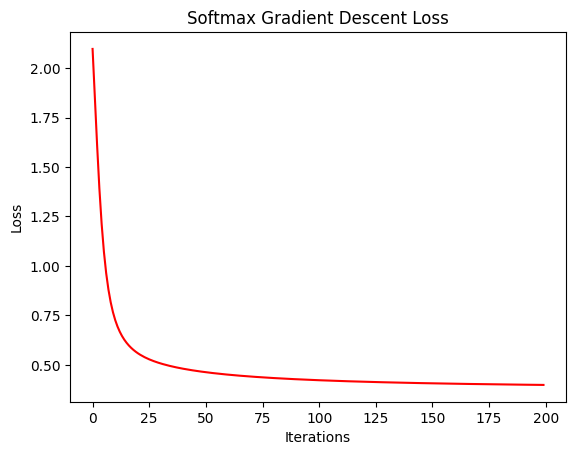

In [ ]:
# 1. One-Hot 轉換
y_onehot_df = pd.get_dummies(data['label'])
y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
print(y[:5])

# 2. 取得特徵
X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用
X = X / 255.0

# 3. 設定超參數
alpha = 0.1 # 降低學習率以確保收斂穩定
iterations = 200
reg = 1e-3

# 4. 初始化權重 (修正處：第 2 維度必須與類別數相同)
# 這樣矩陣運算 X @ w 才會得到 (樣本數, 類別數) 的機率矩陣
w = np.zeros([X.shape[1] + 1, y.shape[1]])

print(f"初始化 w 的形狀: {w.shape}") # 應該是 (5, 3)

# 5. 執行梯度下降
w_history = gradient_descent_softmax(w, X, y, reg, alpha, iterations)

# 6. 取得最後的權重
w_final = w_history[-1]
print("最後的權重 w:\n", w_final)

# 7. 計算與繪製 Loss
loss_history = compute_loss_history(w_history, X, y, reg, OneHot=True)
plt.plot(loss_history, color='r')
plt.title("Softmax Gradient Descent Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
訓練後的準確率 (Accuracy): 90.39%

前 10 筆測試比對 (預測 vs 真實):
預測結果: [7 2 1 0 4 1 4 9 6 9]
真實標籤: [7 2 1 0 4 1 4 9 5 9]


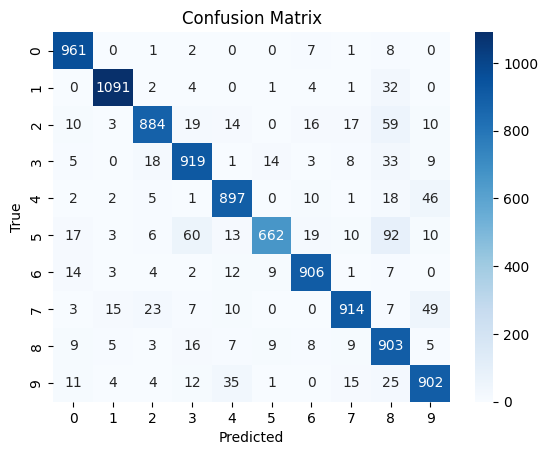

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/mnist_test.csv')

X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用

y_onehot_df = pd.get_dummies(data['label'])
y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
print(y[:5])

def predict_softmax(w, X):
    # 同樣要幫 X 加上截距項 (bias term)
    X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))

    # 計算得分 (scores / logits) -> 形狀為 (樣本數, 類別數)
    scores = np.dot(X_with_bias, w)

    # 取得每一列中數值最大的索引 (index)，即為預測類別
    predictions = np.argmax(scores, axis=1)
    return predictions

# 1. 取得預測結果 (得到 [0, 1, 2, ...])
y_pred = predict_softmax(w_final, X)

# 2. 將 One-Hot 格式的 y 轉回類別索引 (得到 [0, 1, 2, ...])
y_true = np.argmax(y, axis=1)

# 3. 計算準確率 (Accuracy)
accuracy = np.mean(y_pred == y_true)

# 4. 印出結果
print(f"訓練後的準確率 (Accuracy): {accuracy * 100:.2f}%")

# 5. 展示前 10 筆比對結果
print("\n前 10 筆測試比對 (預測 vs 真實):")
print("預測結果:", y_pred[:10])
print("真實標籤:", y_true[:10])

# 6. 混淆矩陣 (可選，觀察模型最容易在哪個類別出錯)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_onehot_df.columns,
            yticklabels=y_onehot_df.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 以批次方式（epoch）進行

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/mnist_train.csv')

In [12]:
def data_iter(X, y, batch_size, shuffle=False):
    """
    批次資料生成器 (Batch Generator)
    m: 樣本總數
    indices: 資料索引清單
    shuffle: 是否要在每一輪 (epoch) 開始前打亂資料順序
    """
    m = len(X)
    indices = list(range(m))
    if shuffle:                 # 如果 shuffle 為 True，隨機打亂索引順序
        np.random.shuffle(indices)

    # 以 batch_size 為步長進行迭代
    for i in range(0, m - batch_size + 1, batch_size):
        # 取得目前批次的索引範圍
        batch_indices = np.array(indices[i: min(i + batch_size, m)])
        # 使用 yield 回傳該批次的特徵與標籤 (不佔用額外記憶體)
        yield X.take(batch_indices, axis=0), y.take(batch_indices, axis=0)

def batch_gradient_descent_softmax(w, X, y, epochs, batchsize=50, shuffle=False,
                                   reg=0., alpha=0.01, gamma=0.8, epsilon=1e-8):
    """
    小批次梯度下降 Softmax 回歸
    epochs: 訓練輪次（全部資料跑過一遍算一個 epoch）
    batchsize: 每個小批次的樣本數，預設為 50
    """
    w_history = []
    # 在特徵矩陣 X 左側補 1（截距項/Bias）
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))

    for epoch in range(epochs):
        # 透過生成器取得每一批的小資料進行訓練
        for X_batch, y_batch in data_iter(X, y, batchsize, shuffle):
            # 計算該批次的梯度
            gradient = gradient_softmax_onehot(w, X_batch, y_batch, reg)

            # 檢查收斂條件
            if np.max(np.abs(gradient)) < epsilon:
                print("梯度已足夠小，停止迭代！")
                print("目前的 epoch 為：", epoch)
                break

            # 更新權重參數
            w = w - (alpha * gradient)

        # --- 修改處：內層迴圈（所有 batch）跑完，才存一次權重 ---
        w_history.append(w.copy()) # 使用 .copy() 確保存下的是當前快照
        print(f"Epoch {epoch+1}/{epochs} 完成")

    return w_history

[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
初始化 w 的形狀: (785, 10)
Epoch 1/5 完成
Epoch 2/5 完成
Epoch 3/5 完成
Epoch 4/5 完成
Epoch 5/5 完成
最後的權重 w:
 [[-0.03739572  0.1911563   0.01322708 ...  0.21677044 -0.54761662
  -0.1253417 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


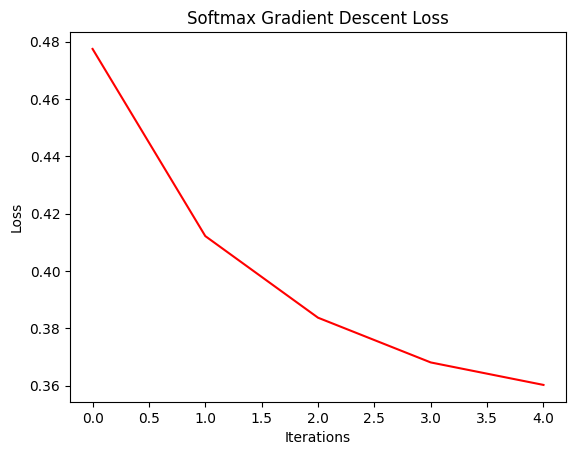

In [ ]:
# 1. One-Hot 轉換
y_onehot_df = pd.get_dummies(data['label'])
y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
print(y[:5])

# 2. 取得特徵
X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用
X = X / 255.0

# 3. 設定超參數
alpha = 0.1
iterations = 200
reg = 1e-3
batchsize = 50
epochs = 5
shuffle = True
gamma = 0.8

# 4. 初始化權重 (修正處：第 2 維度必須與類別數相同)
# 這樣矩陣運算 X @ w 才會得到 (樣本數, 類別數) 的機率矩陣
w = np.zeros([X.shape[1] + 1, y.shape[1]])

print(f"初始化 w 的形狀: {w.shape}") # 應該是 (5, 3)

# 5. 執行梯度下降
w_history = batch_gradient_descent_softmax(w, X, y, epochs, batchsize, shuffle, reg, alpha, gamma)

# 6. 取得最後的權重
w_final = w_history[-1]
print("最後的權重 w:\n", w_final)

# 7. 計算與繪製 Loss
loss_history = compute_loss_history(w_history, X, y, reg, OneHot=True)
plt.plot(loss_history, color='r')
plt.title("Softmax Gradient Descent Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
訓練後的準確率 (Accuracy): 91.15%

前 10 筆測試比對 (預測 vs 真實):
預測結果: [7 2 1 0 4 1 4 9 6 9]
真實標籤: [7 2 1 0 4 1 4 9 5 9]


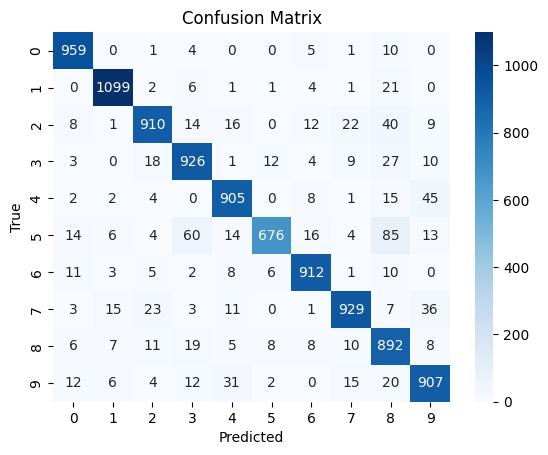

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/mnist_test.csv')

X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用

y_onehot_df = pd.get_dummies(data['label'])
y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
print(y[:5])

def predict_softmax(w, X):
    # 同樣要幫 X 加上截距項 (bias term)
    X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))

    # 計算得分 (scores / logits) -> 形狀為 (樣本數, 類別數)
    scores = np.dot(X_with_bias, w)

    # 取得每一列中數值最大的索引 (index)，即為預測類別
    predictions = np.argmax(scores, axis=1)
    return predictions

# 1. 取得預測結果 (得到 [0, 1, 2, ...])
y_pred = predict_softmax(w_final, X)

# 2. 將 One-Hot 格式的 y 轉回類別索引 (得到 [0, 1, 2, ...])
y_true = np.argmax(y, axis=1)

# 3. 計算準確率 (Accuracy)
accuracy = np.mean(y_pred == y_true)

# 4. 印出結果
print(f"訓練後的準確率 (Accuracy): {accuracy * 100:.2f}%")

# 5. 展示前 10 筆比對結果
print("\n前 10 筆測試比對 (預測 vs 真實):")
print("預測結果:", y_pred[:10])
print("真實標籤:", y_true[:10])

# 6. 混淆矩陣 (可選，觀察模型最容易在哪個類別出錯)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_onehot_df.columns,
            yticklabels=y_onehot_df.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fashion MNIST

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/Fashion MNIST/fashion-mnist_train.csv')

print(data.head())
print(data.label.unique())
print(data.describe())
print(data.info())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
初始化 w 的形狀: (785, 10)
Epoch 1/5 完成
Epoch 2/5 完成
Epoch 3/5 完成
Epoch 4/5 完成
Epoch 5/5 完成
最後的權重 w:
 [[-0.03393702  0.1048754  -0.01925108 ...  0.04845355 -0.11255558
  -0.0227742 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


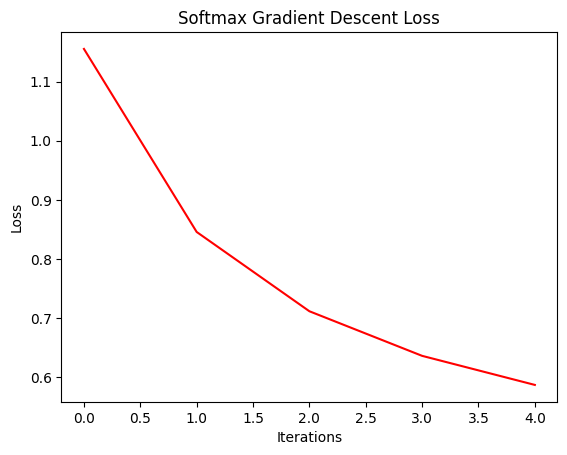

In [27]:
# 1. One-Hot 轉換
y_onehot_df = pd.get_dummies(data['label'])
y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
print(y[:5])

# 2. 取得特徵
X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用
X = X / 255.0

# 3. 設定超參數
alpha = 0.01
iterations = 200
reg = 1e-3
batchsize = 50
epochs = 5
shuffle = True
gamma = 0.8

# 4. 初始化權重 (修正處：第 2 維度必須與類別數相同)
# 這樣矩陣運算 X @ w 才會得到 (樣本數, 類別數) 的機率矩陣
w = np.zeros([X.shape[1] + 1, y.shape[1]])

print(f"初始化 w 的形狀: {w.shape}") # 應該是 (5, 3)

# 5. 執行梯度下降
w_history = batch_gradient_descent_softmax(w, X, y, epochs, batchsize, shuffle, reg, alpha, gamma)

# 6. 取得最後的權重
w_final = w_history[-1]
print("最後的權重 w:\n", w_final)

# 7. 計算與繪製 Loss
loss_history = compute_loss_history(w_history, X, y, reg, OneHot=True)
plt.plot(loss_history, color='r')
plt.title("Softmax Gradient Descent Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
訓練後的準確率 (Accuracy): 86.97%

前 10 筆測試比對 (預測 vs 真實):
預測結果: [7 2 1 0 4 1 4 9 2 9]
真實標籤: [7 2 1 0 4 1 4 9 5 9]


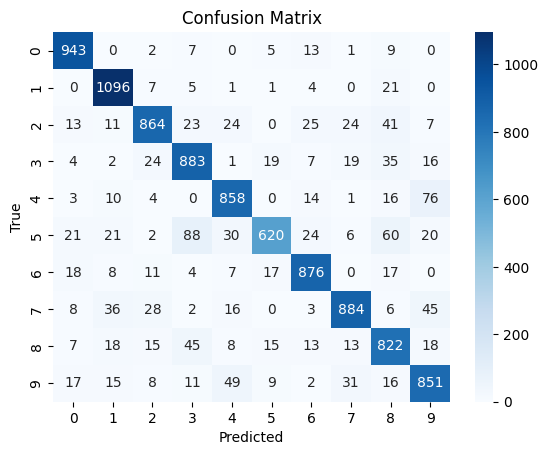

In [28]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine-Learning/Data/mnist_test.csv')

X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用

y_onehot_df = pd.get_dummies(data['label'])
y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
print(y[:5])

def predict_softmax(w, X):
    # 同樣要幫 X 加上截距項 (bias term)
    X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))

    # 計算得分 (scores / logits) -> 形狀為 (樣本數, 類別數)
    scores = np.dot(X_with_bias, w)

    # 取得每一列中數值最大的索引 (index)，即為預測類別
    predictions = np.argmax(scores, axis=1)
    return predictions

# 1. 取得預測結果 (得到 [0, 1, 2, ...])
y_pred = predict_softmax(w_final, X)

# 2. 將 One-Hot 格式的 y 轉回類別索引 (得到 [0, 1, 2, ...])
y_true = np.argmax(y, axis=1)

# 3. 計算準確率 (Accuracy)
accuracy = np.mean(y_pred == y_true)

# 4. 印出結果
print(f"訓練後的準確率 (Accuracy): {accuracy * 100:.2f}%")

# 5. 展示前 10 筆比對結果
print("\n前 10 筆測試比對 (預測 vs 真實):")
print("預測結果:", y_pred[:10])
print("真實標籤:", y_true[:10])

# 6. 混淆矩陣 (可選，觀察模型最容易在哪個類別出錯)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=y_onehot_df.columns,
            yticklabels=y_onehot_df.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()